In [149]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib ipympl

# Parameters
a, b, c = 0.5, 0.7, 0.2
yaw, pitch, roll = 30, 20, 45  # degrees
r = 0.62  # target sphere radius

# Sample 3D points near ellipsoid surface
theta = torch.rand(500) * 2 * torch.pi
phi = torch.acos(2 * torch.rand(500) - 1)
x = a * torch.sin(phi) * torch.cos(theta)
y = b * torch.sin(phi) * torch.sin(theta)
z = c * torch.cos(phi)
points = torch.stack([x, y, z]) + 0.1 * torch.randn(3, 500)

def rotation_matrix_3d(angles):
    alpha, beta, gamma = angles
    return torch.tensor([
        [torch.cos(alpha)*torch.cos(beta), torch.cos(alpha)*torch.sin(beta)*torch.sin(gamma)-torch.sin(alpha)*torch.cos(gamma), torch.cos(alpha)*torch.sin(beta)*torch.cos(gamma)+torch.sin(alpha)*torch.sin(gamma)],
        [torch.sin(alpha)*torch.cos(beta), torch.sin(alpha)*torch.sin(beta)*torch.sin(gamma)+torch.cos(alpha)*torch.cos(gamma), torch.sin(alpha)*torch.sin(beta)*torch.cos(gamma)-torch.cos(alpha)*torch.sin(gamma)],
        [-torch.sin(beta), torch.cos(beta)*torch.sin(gamma), torch.cos(beta)*torch.cos(gamma)]
    ], dtype=torch.double)

def plot_ellipsoid_with_points(a, b, c, yaw, pitch, roll, points, r=0.62, vmin=None, vmax=None, show_gt=True):
    u = torch.linspace(0, 2 * torch.pi, 80)
    v = torch.linspace(0, torch.pi, 40)
    u, v = torch.meshgrid(u, v, indexing="ij")

    x = a * torch.cos(u) * torch.sin(v)
    y = b * torch.sin(u) * torch.sin(v)
    z = c * torch.cos(v)
    ellipsoid = torch.stack((x, y, z), dim=-1).reshape(-1, 3).T  # (3, N)

    angles_rad = torch.deg2rad(torch.tensor([yaw, pitch, roll]))
    R = rotation_matrix_3d(angles_rad)
    rotated = (R @ ellipsoid.double()).T.reshape(x.shape + (3,))
    ellipsoid_xyz = rotated.reshape(-1, 3).T
    surface_dist = torch.norm(ellipsoid_xyz, dim=0) - r
    residuals = surface_dist.reshape(rotated.shape[:2])

    # Normalize residuals for coloring
    # vmin, vmax = -2, 2
    if vmin is None or vmax is None:
        vmin, vmax = residuals.min().item(), residuals.max().item()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.colormaps["RdBu_r"]
    facecolors = cmap(norm(residuals))

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot_surface(
        rotated[..., 0], rotated[..., 1], rotated[..., 2],
        facecolors=facecolors,
        rstride=1, cstride=1,
        antialiased=True, linewidth=0,
        alpha=0.8, shade=False
    )

    # Rotate points to align with ellipsoid
    points = (R @ points.double()).detach()
    ax.scatter(points[0], points[1], points[2], s=1, alpha=0.3, color="black")
    ax.set_axis_off()
    ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(-1, 1)
    ax.set_box_aspect([1, 1, 1])

    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array([])
    fig.colorbar(mappable, ax=ax, shrink=0.6, pad=0.1, label="Residual from sphere (r=0.62)")
    if show_gt:
        u_gt = torch.linspace(0, 2 * torch.pi, 40)
        v_gt = torch.linspace(0, torch.pi, 20)
        u_gt, v_gt = torch.meshgrid(u_gt, v_gt, indexing="ij")
        x_gt = r * torch.cos(u_gt) * torch.sin(v_gt)
        y_gt = r * torch.sin(u_gt) * torch.sin(v_gt)
        z_gt = r * torch.cos(v_gt)

        ax.plot_surface(
            x_gt, y_gt, z_gt,
            color="gray", alpha=0.05
        )

    # plt.show()
    return fig

# Call it


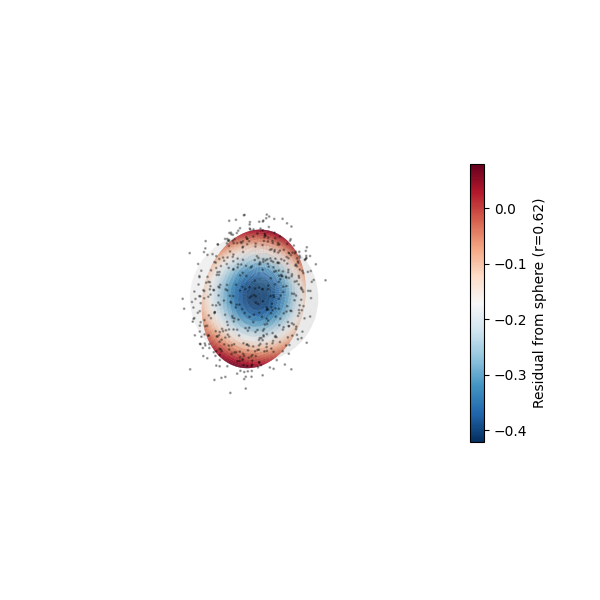

In [142]:
plot_ellipsoid_with_points(a, b, c, yaw, pitch, roll, points, r=0.62)
plt.show()


In [150]:
import plotly.graph_objects as go

def plot_ellipsoid_plotly(a, b, c, yaw, pitch, roll, points, r=0.62, show_gt=True):
    u, v = torch.linspace(0, 2 * torch.pi, 60), torch.linspace(0, torch.pi, 30)
    u, v = torch.meshgrid(u, v, indexing="ij")
    x = a * torch.cos(u) * torch.sin(v)
    y = b * torch.sin(u) * torch.sin(v)
    z = c * torch.cos(v)

    # Rotation
    angles = torch.tensor([yaw, pitch, roll])
    R = rotation_matrix_3d(torch.deg2rad(angles))
    ellipsoid = torch.stack([x, y, z], dim=-1).reshape(-1, 3).T.double()  # (3, N)
    rotated = (R @ ellipsoid).T.reshape(x.shape + (3,))

    # Residuals for color
    ellipsoid_xyz = rotated.reshape(-1, 3).T
    radii = torch.norm(ellipsoid_xyz, dim=0)
    residuals = (radii - r).reshape(rotated.shape[:2]).cpu().numpy()

    surface = go.Surface(
        x=rotated[..., 0].cpu().numpy(),
        y=rotated[..., 1].cpu().numpy(),
        z=rotated[..., 2].cpu().numpy(),
        surfacecolor=residuals,
        colorscale='RdBu',
        cmin=-0.5,
        cmax=0.5,
        opacity=1,
        showscale=True
    )

    # Noisy points (rotated)
    pts = (R @ points.double()).detach().cpu().numpy()
    scatter = go.Scatter3d(
        x=pts[0], y=pts[1], z=pts[2],
        mode='markers',
        marker=dict(size=2, color='black', opacity=0.5)
    )

    # Optional: GT sphere wireframe
    if show_gt:
        u_gt, v_gt = torch.meshgrid(torch.linspace(0, 2*torch.pi, 40), torch.linspace(0, torch.pi, 20))
        x_gt = r * torch.cos(u_gt) * torch.sin(v_gt)
        y_gt = r * torch.sin(u_gt) * torch.sin(v_gt)
        z_gt = r * torch.cos(v_gt)
        sphere = go.Surface(
            x=x_gt, y=y_gt, z=z_gt,
            showscale=False,
            opacity=0.1,
            colorscale=[[0, "gray"], [1, "gray"]],
            surfacecolor=torch.zeros_like(x_gt)
        )
        data = [surface, scatter, sphere]
    else:
        data = [surface, scatter]

    fig = go.Figure(data=data)
    fig.update_layout(scene=dict(
        xaxis=dict(range=[-1, 1]),
        yaxis=dict(range=[-1, 1]),
        zaxis=dict(range=[-1, 1]),
        aspectmode='cube'
    ))
    fig.update_layout(
        scene = dict(
            xaxis = dict(visible=False),
            yaxis = dict(visible=False),
            zaxis =dict(visible=False)
            )
        )
    return fig


In [151]:
fig = plot_ellipsoid_plotly(a, b, c, yaw, pitch, roll, points, r=0.62)
fig.show()


/Users/jeffreyliang/Documents/Honours/venv/lib/python3.12/site-packages/torch/functional.py:513: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3610.)



In [50]:
import torch
import torch.nn.functional as F

def angles_from_normal(normal: torch.Tensor):
    """
    Convert a normal vector to Euler angles (yaw, pitch, roll=0)
    so that rotating the camera forward axis [0,0,1] gives the normal.
    """
    x, y, z = normal.unbind(-1)

    # yaw = azimuth angle in xy-plane
    yaw = torch.atan2(y, x)
    
    # pitch = angle from z axis
    xy_len = torch.sqrt(x**2 + y**2)
    pitch = torch.atan2(z, xy_len)

    roll = torch.zeros_like(yaw)
    return torch.stack([yaw, pitch, roll], dim=-1)  # in radians
def rotation_matrix_zyx(angles):
    """
    Create rotation matrix from Euler angles in radians (yaw, pitch, roll),
    using ZYX (yaw → pitch → roll) convention.
    """
    yaw, pitch, roll = angles.unbind(-1)
    cy, cp, cr = torch.cos(yaw), torch.cos(pitch), torch.cos(roll)
    sy, sp, sr = torch.sin(yaw), torch.sin(pitch), torch.sin(roll)

    R = torch.stack([
        torch.stack([cy * cp, cy * sp * sr - sy * cr, cy * sp * cr + sy * sr], dim=-1),
        torch.stack([sy * cp, sy * sp * sr + cy * cr, sy * sp * cr - cy * sr], dim=-1),
        torch.stack([-sp,     cp * sr,                cp * cr], dim=-1)
    ], dim=-2)  # shape (..., 3, 3)

    return R
normals = F.normalize(torch.tensor([
    [1.0, 1.0, 1.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
]), dim=1)

def build_rotation_from_normal(n: torch.Tensor):
    """
    Given a normal vector, construct a rotation matrix where:
    - the third row is the normal
    - the first two rows are orthonormal in-plane directions
    - no roll is applied
    """
    z = F.normalize(n, dim=0)
    tmp = torch.tensor([0.0, 0.0, 1.0], dtype=z.dtype)
    if torch.allclose(z, tmp):
        tmp = torch.tensor([1.0, 0.0, 0.0], dtype=z.dtype)
    x = F.normalize(torch.cross(tmp, z), dim=0)
    y = torch.cross(z, x)
    return torch.stack([x, y, z], dim=0)  # Shape: (3, 3)

R_stack = torch.stack([build_rotation_from_normal(n) for n in normals])
recovered_dirs = R_stack[:, 2, :]

print("Recovered:\n", recovered_dirs)
print("Original:\n", normals)
print("Match?", torch.allclose(recovered_dirs, normals, atol=1e-5))


Recovered:
 tensor([[0.5774, 0.5774, 0.5774],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000]])
Original:
 tensor([[0.5774, 0.5774, 0.5774],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000]])
Match? True


In [52]:
def euler_angles_from_matrix(R: torch.Tensor):
    """
    Extract yaw, pitch, roll from a rotation matrix using ZYX convention.
    Input R: Tensor of shape (3, 3)
    Returns angles: Tensor of shape (3,) in radians: [yaw, pitch, roll]
    """
    pitch = -torch.arcsin(R[2, 0])  # R[2,0] = -sin(pitch)
    cp = torch.cos(pitch)
    if torch.isclose(cp, torch.tensor(0.0)):
        # Gimbal lock case: pitch = ±90°
        yaw = torch.atan2(-R[0, 1], R[1, 1])
        roll = torch.tensor(0.0)  # Arbitrary
    else:
        roll = torch.atan2(R[2, 1] / cp, R[2, 2] / cp)
        yaw  = torch.atan2(R[1, 0] / cp, R[0, 0] / cp)

    return torch.stack([yaw, pitch, roll])
def batch_euler_angles_from_matrix(Rs: torch.Tensor):
    """
    Input: Rs of shape (N, 3, 3)
    Output: angles of shape (N, 3) in radians
    """
    return torch.stack([euler_angles_from_matrix(R) for R in Rs], dim=0)
R1 = torch.stack([build_rotation_from_normal(n) for n in normals])  # True rotation
angles = batch_euler_angles_from_matrix(R1)                         # Extracted
R2 = rotation_matrix_3d_batch(angles)                               # Reconstructed

print("Match?", torch.allclose(R1, R2, atol=1e-5))
R1, R2


Match? False


(tensor([[[-0.7071,  0.7071,  0.0000],
          [-0.4082, -0.4082,  0.8165],
          [ 0.5774,  0.5774,  0.5774]],
 
         [[ 0.0000,  1.0000,  0.0000],
          [ 0.0000,  0.0000,  1.0000],
          [ 1.0000,  0.0000,  0.0000]],
 
         [[ 0.0000, -1.0000,  0.0000],
          [ 1.0000,  0.0000, -0.0000],
          [ 0.0000,  0.0000,  1.0000]]]),
 tensor([[[-7.0711e-01,  7.0711e-01,  0.0000e+00],
          [-4.0825e-01, -4.0825e-01,  8.1650e-01],
          [ 5.7735e-01,  5.7735e-01,  5.7735e-01]],
 
         [[ 4.3711e-08, -3.0199e-07, -1.0000e+00],
          [ 6.6002e-15,  1.0000e+00, -3.0199e-07],
          [ 1.0000e+00,  6.6002e-15,  4.3711e-08]],
 
         [[-4.3711e-08, -1.0000e+00,  0.0000e+00],
          [ 1.0000e+00, -4.3711e-08,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]]))

In [58]:
from torch import cos, sin

def generate_test_points():
    # Unit cube corners for easy visualization
    from itertools import product
    pts = torch.tensor(list(product([-1, 1], repeat=3)), dtype=torch.float)  # (8, 3)
    return pts  # Shape: (8, 3)
def apply_rotation(R: torch.Tensor, pts: torch.Tensor):
    """
    R: (3, 3) rotation matrix
    pts: (N, 3) points
    Returns: rotated points (N, 3)
    """
    return pts @ R.T
def compare_transformations(R1, R2):
    pts = generate_test_points()
    pts1 = apply_rotation(R1, pts)
    pts2 = apply_rotation(R2, pts)
    
    diff = torch.norm(pts1 - pts2, dim=1)
    print("Pointwise differences:", diff)
    print("Max diff:", diff.max())
    return torch.allclose(pts1, pts2, atol=1e-5)
def rotation_matrix_3d(angles):
    alpha, beta, gamma = angles[0], angles[1], angles[2]
    R = torch.stack([
        torch.stack([cos(alpha)*cos(beta), cos(alpha)*sin(beta)*sin(gamma)-sin(alpha)*cos(gamma), cos(alpha)*sin(beta)*cos(gamma)+sin(alpha)*sin(gamma)]),
        torch.stack([sin(alpha)*cos(beta), sin(alpha)*sin(beta)*sin(gamma)+cos(alpha)*cos(gamma), sin(alpha)*sin(beta)*cos(gamma)-cos(alpha)*sin(gamma)]),
        torch.stack([-sin(beta), cos(beta)*sin(gamma), cos(beta)*cos(gamma)])
    ])
    return R

# Build rotation matrix from normal
normal = F.normalize(torch.tensor([1.0, 1.0, 1.0]), dim=0)
R1 = build_rotation_from_normal(normal)

# Extract angles, rebuild matrix
angles = euler_angles_from_matrix(R1)
R2 = rotation_matrix_3d(angles)

# Compare transformation effects
compare_transformations(R1, R2)


Pointwise differences: tensor([1.4600e-07, 8.4294e-08, 1.6859e-07, 2.0648e-07, 2.0648e-07, 1.6859e-07,
        8.4294e-08, 1.4600e-07])
Max diff: tensor(2.0648e-07)


True

In [62]:
import torch
import torch.nn.functional as F
from itertools import product

# --- Rotation utilities ---

def build_rotation_from_normal(n: torch.Tensor):
    z = F.normalize(n, dim=0)
    tmp = torch.tensor([0.0, 0.0, 1.0], dtype=z.dtype)
    if torch.allclose(z, tmp):
        tmp = torch.tensor([1.0, 0.0, 0.0], dtype=z.dtype)
    x = F.normalize(torch.cross(tmp, z), dim=0)
    y = torch.cross(z, x)
    return torch.stack([x, y, z], dim=0)  # Shape: (3, 3)

def batch_rotation_from_normals(normals):
    return torch.stack([build_rotation_from_normal(n) for n in normals])

def rotation_matrix_3d(angles):
    yaw, pitch, roll = angles.unbind(-1)
    cy, cp, cr = torch.cos(yaw), torch.cos(pitch), torch.cos(roll)
    sy, sp, sr = torch.sin(yaw), torch.sin(pitch), torch.sin(roll)
    R = torch.stack([
        torch.stack([cy * cp, cy * sp * sr - sy * cr, cy * sp * cr + sy * sr], dim=-1),
        torch.stack([sy * cp, sy * sp * sr + cy * cr, sy * sp * cr - cy * sr], dim=-1),
        torch.stack([-sp, cp * sr, cp * cr], dim=-1)
    ], dim=-2)
    return R

def euler_angles_from_matrix(R: torch.Tensor):
    pitch = -torch.arcsin(R[2, 0])
    cp = torch.cos(pitch)
    if torch.isclose(cp, torch.tensor(0.0, dtype=R.dtype)):
        yaw = torch.atan2(-R[0, 1], R[1, 1])
        roll = torch.tensor(0.0, dtype=R.dtype)
    else:
        roll = torch.atan2(R[2, 1] / cp, R[2, 2] / cp)
        yaw = torch.atan2(R[1, 0] / cp, R[0, 0] / cp)
    return torch.stack([yaw, pitch, roll])

def batch_euler_angles_from_matrix(Rs: torch.Tensor):
    return torch.stack([euler_angles_from_matrix(R) for R in Rs], dim=0)

def generate_test_points():
    pts = torch.tensor(list(product([-1, 1], repeat=3)), dtype=torch.double)
    return pts  # (8, 3)

def apply_rotation(R: torch.Tensor, pts: torch.Tensor):
    return pts @ R.T

def compare_transformations_batch(R1, R2):
    pts = generate_test_points()
    transformed1 = torch.stack([apply_rotation(R, pts) for R in R1])
    transformed2 = torch.stack([apply_rotation(R, pts) for R in R2])
    diffs = torch.norm(transformed1 - transformed2, dim=-1).max(dim=-1).values
    return diffs

# --- Test on provided normals ---

normals = torch.tensor([
    [1, 0, 0],
    [0, 1, 0],       
    [0, 0, 1],       
    [1, 1, 1],
    [1, -1, 1], 
    [-1, 1, 1],
    [-1, -1, 1],
    [-1, 1, 1]
], dtype=torch.double)
normals = F.normalize(normals, dim=1)

R1 = batch_rotation_from_normals(normals)
angles = batch_euler_angles_from_matrix(R1)
R2 = rotation_matrix_3d(angles)



# Compare transformations
max_diffs = compare_transformations_batch(R1, R2)
max_diffs
torch.rad2deg(angles)

tensor([[ -90.0000,  -90.0000,    0.0000],
        [ 180.0000,   -0.0000,   90.0000],
        [  90.0000,   -0.0000,    0.0000],
        [-150.0000,  -35.2644,   45.0000],
        [ -30.0000,  -35.2644,  -45.0000],
        [ 150.0000,   35.2644,   45.0000],
        [  30.0000,   35.2644,  -45.0000],
        [ 150.0000,   35.2644,   45.0000]], dtype=torch.float64)

In [64]:
torch.rad2deg(batch_euler_angles_from_matrix(R2))


tensor([[ -90.0000,  -90.0000,    0.0000],
        [ 180.0000,   -0.0000,   90.0000],
        [  90.0000,   -0.0000,    0.0000],
        [-150.0000,  -35.2644,   45.0000],
        [ -30.0000,  -35.2644,  -45.0000],
        [ 150.0000,   35.2644,   45.0000],
        [  30.0000,   35.2644,  -45.0000],
        [ 150.0000,   35.2644,   45.0000]], dtype=torch.float64)